# Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Preparing Weather Data

In [2]:
weather=pd.read_csv("../MCI_30_Corrected.csv")
weather['DATE']= pd.to_datetime(weather['DATE'])
weather.set_index(["DATE"],inplace=True)
weather = weather.loc['2000-01-04':'2022-12-26']

In [3]:
weekly = weather.groupby(pd.Grouper(freq='7D')).mean()

In [4]:
weekly

,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
DATE,,,,,,
2000-01-04,11.088571,0.002857,0.000000,0.000000,45.857143,24.142857
2000-01-11,11.247143,0.000000,0.000000,0.000000,46.857143,26.714286
2000-01-18,9.620000,0.011429,0.171429,0.142857,42.000000,17.571429
2000-01-25,9.491429,0.031429,0.457143,1.428571,27.571429,15.000000
2000-02-01,10.385714,0.000000,0.000000,0.428571,44.142857,20.571429
...,...,...,...,...,...,...
2022-11-22,8.212857,0.044286,0.000000,0.000000,56.714286,32.285714
2022-11-29,12.238571,0.000000,0.000000,0.000000,49.285714,24.714286
2022-12-06,7.510000,0.024286,0.000000,0.000000,45.571429,33.428571


# Preparing Drought Categories

In [5]:
DM=pd.read_csv("../dm_Full.csv")
df_reverse_rows = DM.iloc[::-1]
test=df_reverse_rows.reset_index(drop=True)
test['Drought_Level'] = test[["None","D0","D1","D2","D3","D4"]].idxmax(axis=1)

In [6]:
test2=test[["ValidStart","Drought_Level"]].copy()
test2['ValidStart'] = pd.to_datetime(test2.ValidStart)
#test2['ValidStart'] = pd.to_datetime(test2.ValidStart, format='%Y/%m/%d')   
test2.set_index("ValidStart",inplace=True)

In [7]:
test3=test2.replace({'Drought_Level':{'None':0,'D0':1,'D1':1,'D2':1,'D3':1,'D4':1}})
test3

,Drought_Level
ValidStart,
2000-01-04,1
2000-01-11,1
2000-01-18,1
2000-01-25,1
2000-02-01,1
...,...
2022-11-22,1
2022-11-29,1
2022-12-06,1


# Merging Data Sets

In [8]:
a=weekly.merge(test3, how='outer',left_index=True, right_index=True)
a

,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Drought_Level
DATE,,,,,,,
2000-01-04,11.088571,0.002857,0.000000,0.000000,45.857143,24.142857,1
2000-01-11,11.247143,0.000000,0.000000,0.000000,46.857143,26.714286,1
2000-01-18,9.620000,0.011429,0.171429,0.142857,42.000000,17.571429,1
2000-01-25,9.491429,0.031429,0.457143,1.428571,27.571429,15.000000,1
2000-02-01,10.385714,0.000000,0.000000,0.428571,44.142857,20.571429,1
...,...,...,...,...,...,...,...
2022-11-22,8.212857,0.044286,0.000000,0.000000,56.714286,32.285714,1
2022-11-29,12.238571,0.000000,0.000000,0.000000,49.285714,24.714286,1
2022-12-06,7.510000,0.024286,0.000000,0.000000,45.571429,33.428571,1


In [9]:
#a.to_csv('weekly_DM.csv')

# EDA

In [10]:
a.describe()

,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Drought_Level
count,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000
mean,10.118985,0.106876,0.048135,0.161122,65.623019,45.249970,0.377815
std,2.005915,0.148907,0.171360,0.686997,18.959900,18.319356,0.485043
min,4.984286,0.000000,0.000000,0.000000,9.142857,1.285714,0.000000
25%,8.725000,0.005714,0.000000,0.000000,49.928571,29.714286,0.000000
50%,9.970000,0.050000,0.000000,0.000000,67.714286,46.142857,0.000000
75%,11.440000,0.152143,0.000000,0.000000,82.285714,62.428571,1.000000
max,17.255714,1.092857,1.542857,8.857143,101.571429,75.714286,1.000000


array([<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>], dtype=object)

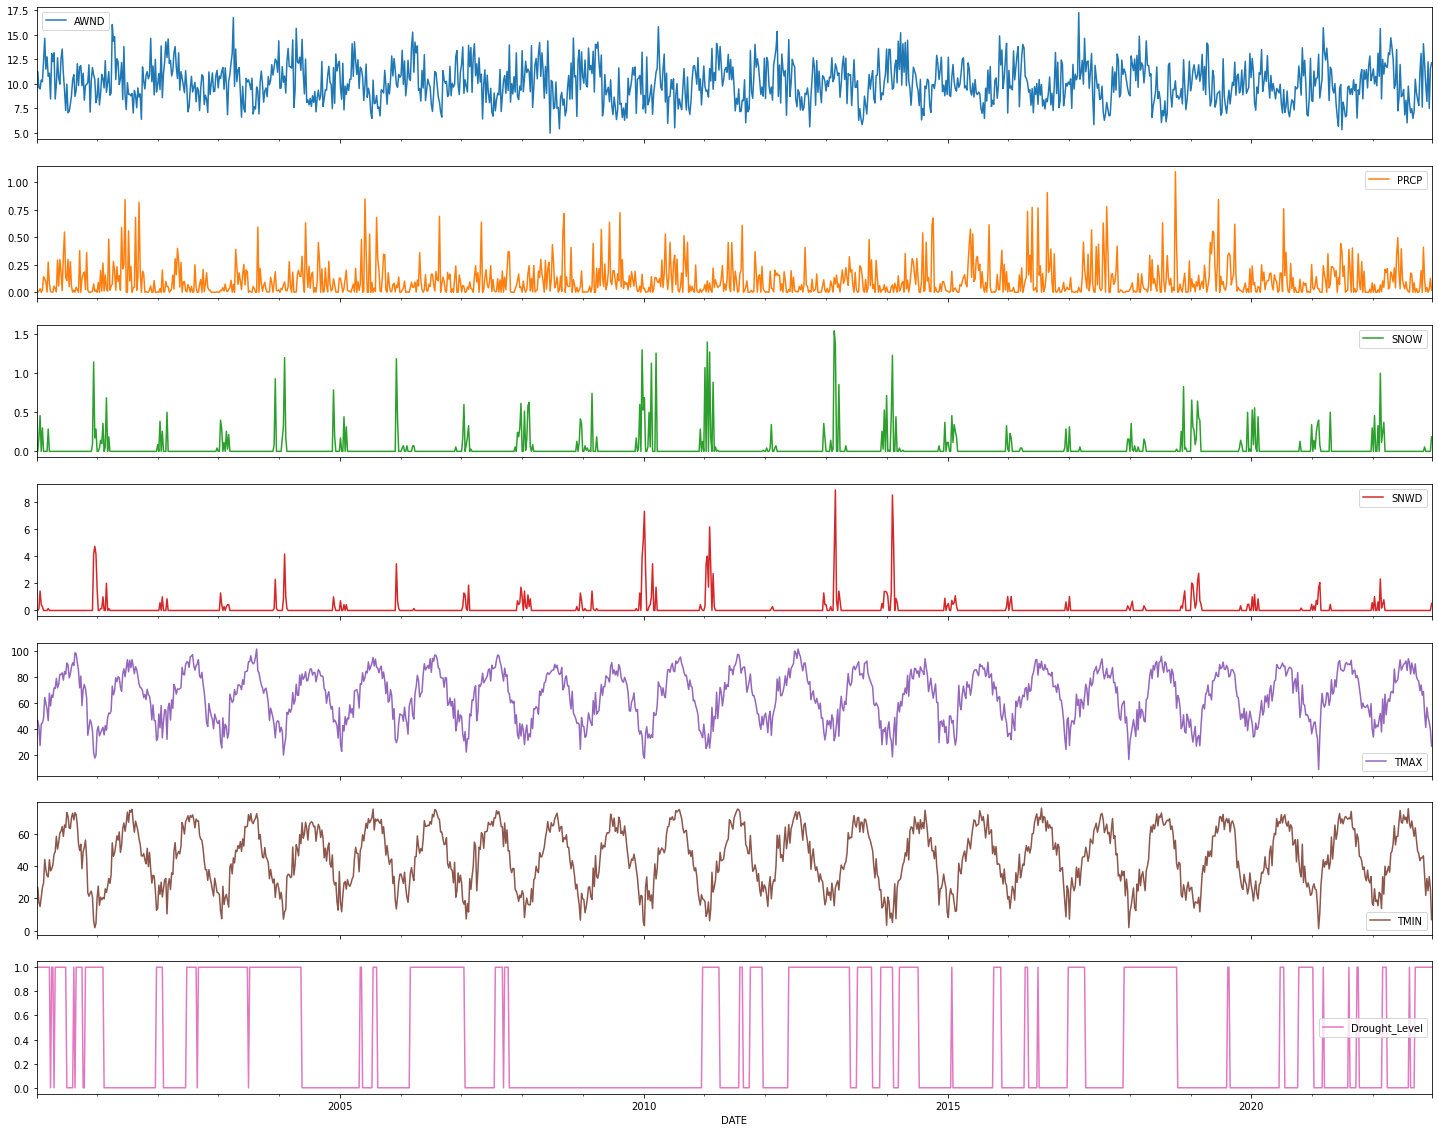

In [11]:
a.plot(subplots=True, figsize=(25,20))

array([[<AxesSubplot:title={'center':'AWND'}>,
        <AxesSubplot:title={'center':'PRCP'}>,
        <AxesSubplot:title={'center':'SNOW'}>],
       [<AxesSubplot:title={'center':'SNWD'}>,
        <AxesSubplot:title={'center':'TMAX'}>,
        <AxesSubplot:title={'center':'TMIN'}>],
       [<AxesSubplot:title={'center':'Drought_Level'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

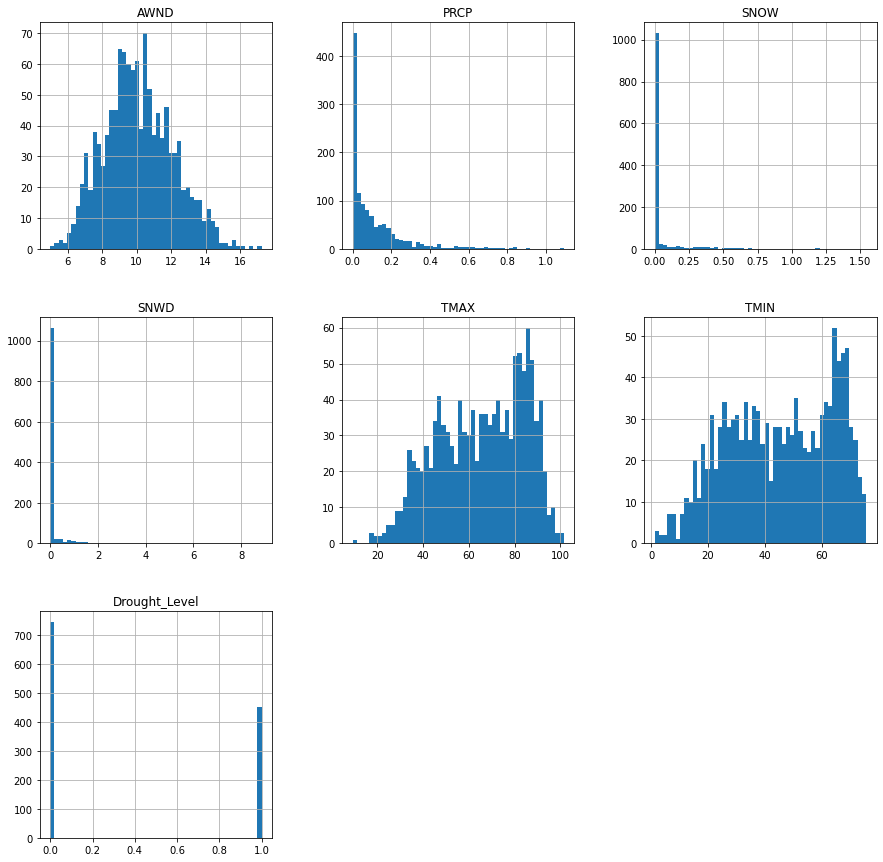

In [12]:
a.hist(bins=50,figsize=(15,15))

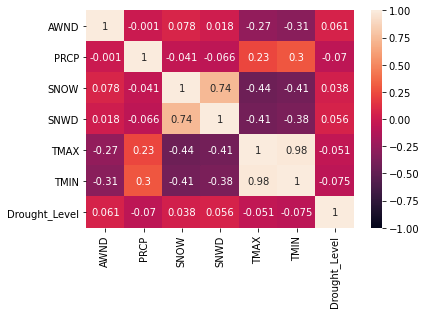

In [13]:
heatmap = sns.heatmap(a.corr(), vmin=-1, vmax=1, annot=True)

# Feature Selection

In [14]:
y=a[["Drought_Level"]].values
x=a[["AWND","PRCP","SNOW","SNWD","TMAX","TMIN"]].values

In [15]:
y=a.pop("Drought_Level")
x=a

In [16]:
train_X,test_X,train_Y,test_Y=train_test_split(x,y,test_size=0.25,shuffle=False)

In [17]:
train_X_norm=preprocessing.normalize(train_X)
test_X_norm=preprocessing.normalize(test_X)

# Decision Trees

In [18]:
model_1= DecisionTreeClassifier()
model_1.fit(train_X,train_Y)

DecisionTreeClassifier()

In [19]:
sfs1 = SFS(model_1, 
           k_features="best",
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=10)

sfs1 = sfs1.fit(train_X, train_Y)

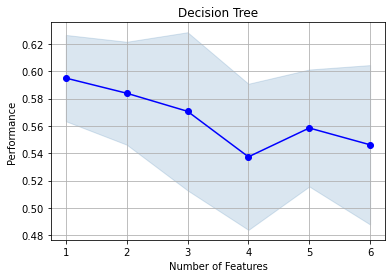

In [20]:
metric_dict1 = sfs1.get_metric_dict(confidence_interval=0.95)
fig1 = plot_sfs(metric_dict1, kind='std_dev')
plt.title('Decision Tree')
plt.grid()
plt.show()

In [21]:
print('Best subset:', sfs1.k_feature_idx_)
print('Best subset (corresponding names):', x.columns[:][list(sfs1.k_feature_idx_)])

Best subset: (2,)
Best subset (corresponding names): Index(['SNOW'], dtype='object')


# Random Forest

In [22]:
model_2= RandomForestClassifier()
model_2.fit(train_X,train_Y)

RandomForestClassifier()

In [23]:
sfs2 = SFS(model_2, 
           k_features="best",
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=10)

sfs2 = sfs2.fit(train_X, train_Y)

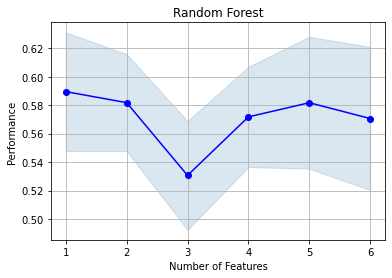

In [24]:
metric_dict2 = sfs2.get_metric_dict(confidence_interval=0.95)
fig1 = plot_sfs(metric_dict2, kind='std_dev')
plt.title('Random Forest')
plt.grid()
plt.show()

In [25]:
print('Best subset:', sfs2.k_feature_idx_)
print('Best subset (corresponding names):', x.columns[:][list(sfs2.k_feature_idx_)])

Best subset: (2,)
Best subset (corresponding names): Index(['SNOW'], dtype='object')


# Logistic Regression

In [26]:
model_3= LogisticRegression()
model_3.fit(train_X_norm,train_Y)

LogisticRegression()

In [27]:
sfs3 = SFS(model_3, 
           k_features="best",
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=10)

sfs3 = sfs3.fit(train_X_norm, train_Y)

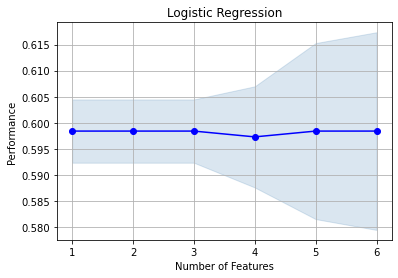

In [28]:
metric_dict3 = sfs3.get_metric_dict(confidence_interval=0.95)
fig1 = plot_sfs(metric_dict3, kind='std_dev')
plt.title('Logistic Regression')
plt.grid()
plt.show()

In [29]:
print('Best subset:', sfs3.k_feature_idx_)
print('Best subset (corresponding names):', x.columns[:][list(sfs3.k_feature_idx_)])

Best subset: (0,)
Best subset (corresponding names): Index(['AWND'], dtype='object')


# k-Nearest Neighbors

In [30]:
model_4= KNeighborsClassifier(n_neighbors=17)
model_4.fit(train_X_norm,train_Y)

KNeighborsClassifier(n_neighbors=17)

In [31]:
sfs4 = SFS(model_4, 
           k_features="best",
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=10)

sfs4 = sfs4.fit(train_X_norm, train_Y)

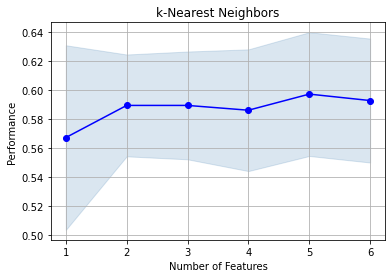

In [32]:
metric_dict4 = sfs4.get_metric_dict(confidence_interval=0.95)
fig1 = plot_sfs(metric_dict4, kind='std_dev')
plt.title('k-Nearest Neighbors')
plt.grid()
plt.show()

In [33]:
print('Best subset:', sfs4.k_feature_idx_)
print('Best subset (corresponding names):', x.columns[:][list(sfs4.k_feature_idx_)])

Best subset: (0, 1, 3, 4, 5)
Best subset (corresponding names): Index(['AWND', 'PRCP', 'SNWD', 'TMAX', 'TMIN'], dtype='object')
